In [1]:
import pandas as pd
import numpy as np
import random

# text preprocessing
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# save and load a file
import pickle

import warnings

In [2]:
warnings.filterwarnings("ignore")

Dataset is obtained to create the initial models

In [3]:
df_train = pd.read_csv('data/data_train.csv')
df_test = pd.read_csv('data/data_test.csv')

X_train = df_train.Text
X_test = df_test.Text

y_train = df_train.Emotion
y_test = df_test.Emotion

class_names = ['joy', 'sadness', 'anger', 'neutral', 'fear']
data = pd.concat([df_train, df_test])

print('size of training set: %s' % (len(df_train['Text'])))
print('size of validation set: %s' % (len(df_test['Text'])))
print(data.Emotion.value_counts())

data.head()

size of training set: 7934
size of validation set: 3393
joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...


In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [5]:
def preprocess_and_tokenize(data):    

    #remove html markup
    data = re.sub("(<.*?>)", "", data)

    #remove urls
    data = re.sub(r'http\S+', '', data)
    
    #remove hashtags and @names
    data= re.sub(r"(#[\d\w\.]+)", '', data)
    data= re.sub(r"(@[\d\w\.]+)", '', data)

    #remove punctuation and non-ascii digits
    data = re.sub("(\\W|\\d)", " ", data)
    
    #remove whitespace
    data = data.strip()
    
    # tokenization with nltk
    data = word_tokenize(data)
    
    # stemming with nltk
    porter = PorterStemmer()
    stem_data = [porter.stem(word) for word in data]
        
    return stem_data

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/Stacey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# TFIDF, unigrams and bigrams
vect = TfidfVectorizer(tokenizer=preprocess_and_tokenize, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

# fit on our complete corpus
vect.fit_transform(data.Text)

# transform testing and training datasets to vectors
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

Accuracy: 67.02%

F1 Score: 67.02

COnfusion Matrix:
 [[469  32  44  28 120]
 [ 73 420  55  16 115]
 [ 56  18 475  68  90]
 [ 61  20  76 385  96]
 [ 68  20  48  15 525]]


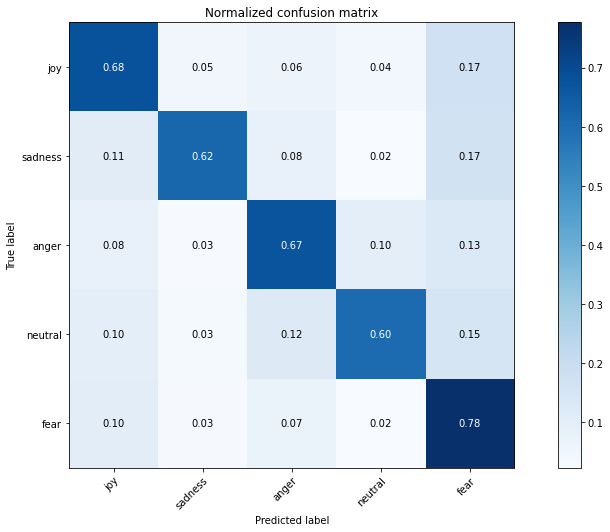

In [8]:
nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

ynb_pred = nb.predict(X_test_vect)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ynb_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ynb_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ynb_pred))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, ynb_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

###  Random Forrest

Accuracy: 62.63%

F1 Score: 62.63

COnfusion Matrix:
 [[391  97  68  65  72]
 [ 75 437  55  60  52]
 [ 65  60 425 102  55]
 [ 46  23  41 500  28]
 [ 87  81  84  52 372]]


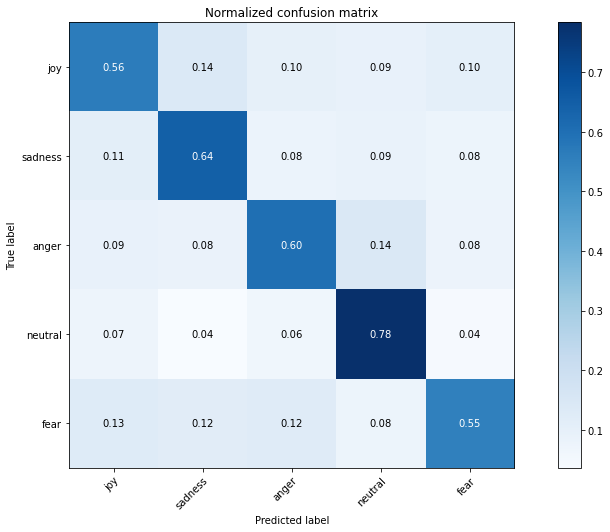

In [9]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train_vect, y_train)

yrf_pred = rf.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, yrf_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, yrf_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, yrf_pred))

plot_confusion_matrix(y_test, yrf_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

###  Logistic Regression

Accuracy: 69.35%

F1 Score: 69.35

COnfusion Matrix:
 [[456  67  44  68  58]
 [ 65 483  42  50  39]
 [ 56  34 476 101  40]
 [ 41  23  42 498  34]
 [ 82  60  51  43 440]]


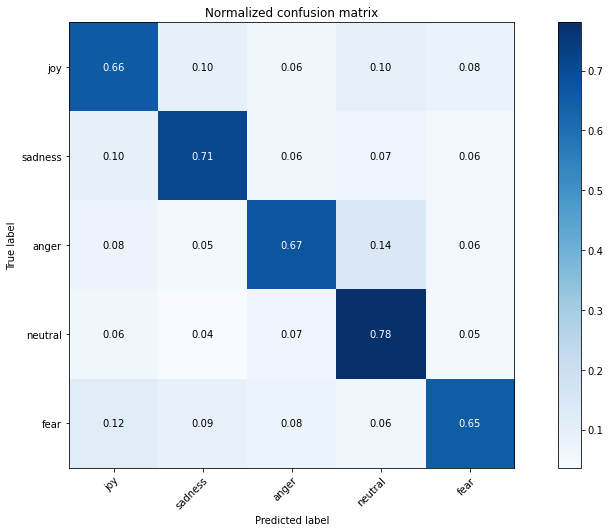

In [10]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
log.fit(X_train_vect, y_train)

ylog_pred = log.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ylog_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ylog_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ylog_pred))

plot_confusion_matrix(y_test, ylog_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

###  Linear Support Vector

Accuracy: 72.71%

F1 Score: 72.71

COnfusion Matrix:
 [[490  49  41  58  55]
 [ 53 508  34  40  44]
 [ 50  33 498  91  35]
 [ 34  23  38 505  38]
 [ 72  43  53  42 466]]


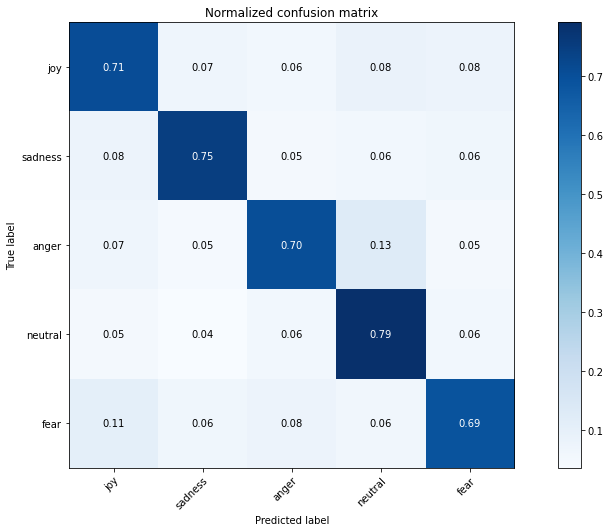

In [11]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, y_train)

ysvm_pred = svc.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ysvm_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ysvm_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ysvm_pred))

plot_confusion_matrix(y_test, ysvm_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

As linear SVC gave the best accuracy. It is going to be use for the recommender system to obtain emotion.

In [12]:
#Create pipeline with our tf-idf vectorizer and LinearSVC model
svm_model = Pipeline([
    ('tfidf', vect),
    ('clf', svc),
])

In [13]:
# save the model
filename = 'models/tfidf_svm.sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [14]:
model = pickle.load(open(filename, 'rb'))

message = 'Trying to make sense of the horrors of World War II Death relates the story of Liesel a young German girl whose book stealing and story telling talents help sustain her family and the Jewish man they are hiding as well as their neighbors ' 
model.predict([message])

array(['fear'], dtype=object)

Book dataset is imported

In [15]:
df=pd.read_csv('book_data.csv',nrows=1000)
df.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.780440e+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.780440e+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.780060e+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.780680e+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.780320e+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...


In [16]:
df['book_desc']=df['book_desc'].str.replace(r'[\W_]+',' ')

In [17]:
df=df[df['book_desc'].notnull()]

In [18]:
df=df[-(df['book_desc']==' ')]

In [19]:
df.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous Losing means cert...,NaN,Hardcover,9.780440e+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.780440e+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.780060e+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.780680e+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
4,Stephenie Meyer,About three things I was absolutely positive F...,NaN,Paperback,9.780320e+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...


As we will be working exclusively with english books we remove the books in other languages.

In [20]:
import langdetect as ld
def is_en(txt):
    try:
        return ld.detect(txt)=='en'
    except: 
        return False
    
df=df[df['book_desc'].apply(is_en)]

In [21]:
df.reset_index(drop=True)

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous Losing means cert...,NaN,Hardcover,9.780440e+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.780440e+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.780060e+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Stephenie Meyer,About three things I was absolutely positive F...,NaN,Paperback,9.780320e+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...
4,Markus Zusak,Trying to make sense of the horrors of World W...,First American Edition (US / CAN),Hardcover,9.780380e+12,552 pages,4.36,1485632,100821,The Book Thief,Historical|Historical Fiction|Fiction|Young Adult,https://images.gr-assets.com/books/1522157426l...
...,...,...,...,...,...,...,...,...,...,...,...,...
974,Terry Pratchett,Arch swindler Moist Van Lipwig never believed ...,NaN,Mass Market Paperback,9.780060e+12,394 pages,4.37,89341,2540,Going Postal,Fantasy|Fiction|Humor,https://images.gr-assets.com/books/1388236899l...
975,Frank Miller|Klaus Janson|Lynn Varley,This masterpiece of modern comics storytelling...,NaN,Hardcover,9.781560e+12,197 pages,4.25,149561,3081,Batman: The Dark Knight Returns,Sequential Art|Comics|Sequential Art|Graphic N...,https://images.gr-assets.com/books/1327892039l...
976,Murasaki Shikibu|Royall Tyler,See an alternate cover edition here Written in...,NaN,Paperback,9.780140e+12,1182 pages,3.71,8738,770,The Tale of Genji,Classics|Fiction|Cultural|Japan|Asian Literatu...,https://images.gr-assets.com/books/1401241319l...
977,Brandon Sanderson,Vin the street urchin who has grown into the m...,NaN,Hardcover,9.780770e+12,590 pages,4.36,206309,10328,The Well of Ascension,Fantasy|Fiction|Fantasy|Epic Fantasy|Fantasy|H...,https://images.gr-assets.com/books/1480717596l...


In [22]:
df["index"]=df.index

In [23]:
df.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url,index
0,Suzanne Collins,Winning will make you famous Losing means cert...,NaN,Hardcover,9.780440e+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...,0
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.780440e+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...,1
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.780060e+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...,2
4,Stephenie Meyer,About three things I was absolutely positive F...,NaN,Paperback,9.780320e+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...,4
5,Markus Zusak,Trying to make sense of the horrors of World W...,First American Edition (US / CAN),Hardcover,9.780380e+12,552 pages,4.36,1485632,100821,The Book Thief,Historical|Historical Fiction|Fiction|Young Adult,https://images.gr-assets.com/books/1522157426l...,5


In [24]:
descriptions=list(df['book_desc'].values)

In [25]:
emotions=model.predict(descriptions)

In [26]:
df['emotions']=emotions

In [27]:
#Function to detect emotion from a string
def user_tone(search):
    return model.predict([search])

The following block is used to test cosine similarity. Later it was decided to not use it.

In [28]:
def combined_features(row):
    return row["book_desc"]+" "+row["genres"]
def get_index_from_title(title):
    try:
        return df[df.book_title == title]["index"].values[0]
    except IndexError:
        return None
def get_book_from_index(index):
    return df[df.index==index]["book_title"].values[0]
def similarBooks(liked_book):
    global df
    df["combined_features"]=df.apply(combined_features,axis=1)
    cv=CountVectorizer()
    count_matrix=cv.fit_transform(df["combined_features"])
    cosine_sim=cosine_similarity(count_matrix)
    book_index=get_index_from_title(liked_book)
    if book_index is None:
        print("Sorry, we do not have information on the book you read")
        return None
    similar_books=list(enumerate(cosine_sim[book_index]))
    sorted_similar_books=sorted(similar_books,key=lambda x:x[1],reverse=True)
    i=0
    for book in sorted_similar_books:
        print(get_book_from_index(book[0]))
        i=i+1
        if i>5:
            break
    
    

In [29]:
similarBooks("Harry Potter")

Sorry, we do not have information on the book you read


Following  is a function that is used to generate chat functionality of chatbot.

In [30]:
def chat():
    search=""
    print("Let's start from a quick quiz to get to know you better!")
    print("In your opinion, how are you feeling today?")
    print("A:Pretty good")
    print("B:Tired and ready for the day to end")
    print("C:Like there is no point")
    print("D:Pissed off!")
    q1=input("Please, Enter A, B, C or D or you can type in how you feel:)")
    if q1=="A":
        search+="Pretty good"
    elif q1=="B":
        search+="Tired and ready for the day to end"
    elif q1=="C":
        search+="Like there is no point"
    elif q1=="D":
        search+="Pissed off!"
    else:
        search+=" "+q1
    print()
    print("The sun is shining and the temperature is just right. What are you going to do today?")
    print("A:Get outside and do something great")
    print("B:Watch TV, play on my phone, nothing too exciting")
    print("C:The same thing I do every day")
    print("D:Who knows! I am sure someone will come along and ruin my day")
    q2=input("Please, Enter A, B, C or D or you can type in your own choice:)")
    if q2=="A":
        search+=" Get outside and do something great"
    elif q2=="B":
        search+=" Watch TV, play on my phone, nothing too exciting"
    elif q2=="C":
        search+=" The same thing I do every day"
    elif q2=="D":
        search+=" Who knows! I am sure someone will come along and ruin my day"
    else:
        search+=" "+q2
    print()
    print("If you could do anything you wanted, right now, you would:")
    print("A:Go home to be with your family")
    print("B:Go on a walk alone")
    print("C:Sleep")
    print("D:Scream at the top of your lungs!")
    q3=input("Please, Enter A, B, C or D or you can type in what you would do:)")
    if q3=="A":
        search+=" Go home to be with your family"
    elif q3=="B":
        search+=" Go on a walk alone"
    elif q3=="C":
        search+=" Sleep"
    elif q3=="D":
        search+=" Scream at the top of your lungs!"
    else:
        search+=" "+q3
    print()
    print("Choose a color:")
    print("A:Blue")
    print("B:Black")
    print("C:Red")
    print("D:White")
    q4=input("Please, Enter A, B, C or D or you can type in your own color:)")
    if q4=="A":
        search+=" Blue"
    elif q4=="B":
        search+=" Black"
    elif q4=="C":
        search+=" Red"
    elif q4=="D":
        search+=" White"
    else:
        search+=" "+q4
    print()
    print("Your friend calls you and wants to chat. You:")
    print("A:Ignore the call")
    print("B:Answer and talk for over an hour")
    print("C:Answer and don't say much and the conversation only lasts 5 minutes")
    print("D:Answer and begin ranting about everything you hate")
    q5=input("Please, Enter A, B, C or D or you can type in What ou would do:)")
    if q5=="A":
        search+=" Ignore the call"
    elif q5=="B":
        search+=" Answer and talk for over an hour"
    elif q5=="C":
        search+=" Answer and don't say much and the conversation only lasts 5 minutes"
    elif q5=="D":
        search+=" Answer and begin ranting about everything you hate"
    else:
        search+=" "+q5
        
    return search
    
    

The following function recommends the books and returns a dataframe of books based on emotion.

In [31]:
def recommendBooks(tone):
    all_books_name=list(df[df['emotions']==tone[0]]['book_title'])
    number_pages=list(df[df['emotions']==tone[0]]['book_pages'])
    genre=list(df[df['emotions']==tone[0]]['genres'])
    idx=df.index
    idxs=idx[df['emotions']==tone[0]]
    idx_list=idxs.tolist()
    dfr=pd.DataFrame({'Index':idx_list,'book':all_books_name,'Number of Pages':number_pages,'Genres':genre})
    if tone[0]!="neutral":
        #return dfr.sample(n=10)
        return dfr
    else:
        return dfr


In [32]:
chat()

Let's start from a quick quiz to get to know you better!
In your opinion, how are you feeling today?
A:Pretty good
B:Tired and ready for the day to end
C:Like there is no point
D:Pissed off!
Please, Enter A, B, C or D or you can type in how you feel:)A

The sun is shining and the temperature is just right. What are you going to do today?
A:Get outside and do something great
B:Watch TV, play on my phone, nothing too exciting
C:The same thing I do every day
D:Who knows! I am sure someone will come along and ruin my day
Please, Enter A, B, C or D or you can type in your own choice:)A

If you could do anything you wanted, right now, you would:
A:Go home to be with your family
B:Go on a walk alone
C:Sleep
D:Scream at the top of your lungs!
Please, Enter A, B, C or D or you can type in what you would do:)A

Choose a color:
A:Blue
B:Black
C:Red
D:White
Please, Enter A, B, C or D or you can type in your own color:)A

Your friend calls you and wants to chat. You:
A:Ignore the call
B:Answer and 

'Pretty good Get outside and do something great Go home to be with your family Blue Ignore the call'

The following functions first take emotion from chat and then get the books and based on user choice of genre returns recommended books.

In [33]:
def get_book_from_index(index):
    return df[df.index==index]["book_title"].values[0]
def RecommenderSystem():
    global df
    query=chat()
    tone=user_tone(query)
    print("Great! Le me ask you the last question to understand your preferences")
    genre=input("Which genre would you like to read?")
    books=recommendBooks(tone)
    books1=pd.DataFrame()
    b=[]
    p=[]
    g=[]
    for i in range(len(books.Genres)):
        if genre in books["Genres"][i]:
            b.append(books["book"][i])
            p.append(books["Number of Pages"][i])
            g.append(books["Genres"][i])
    books1["Book"]=b
    books1["Number of Pages"]=p
    books1["Genres"]=g
    print("Now I can definitely offer you the list of books. How about reading one of those books?")
    print(books1.sample(n=5))
    
    
    qq="No"
    while qq!="Yes":
        print("Is it something you were looking for?")
        qq=input("Yes/No: ")
        if qq=="Yes":
            print("Awesome, glad you found the perfect match! Enjoy the journey! PS: when you're done, please rate book with emotion. For even more personalised next recommendation:)")
            final_choice=input("Final book that you have choses to read:")
            print("What do you feel from the given emotions:")
            print("joy, sadness, anger, neutral, fear")
            emotion=input("Please enter one of the given emotions: ")
            idx=books[books['book']==final_choice]['Index']
            df['emotions'][idx]=emotion
            break
        else:
            print("Looks like I was wrong:( Let me offer you another list of books. How about reading one of those books?")
            print(books1.sample(n=5))
    return None

In [36]:
RecommenderSystem()

Let's start from a quick quiz to get to know you better!
In your opinion, how are you feeling today?
A:Pretty good
B:Tired and ready for the day to end
C:Like there is no point
D:Pissed off!
Please, Enter A, B, C or D or you can type in how you feel:)A

The sun is shining and the temperature is just right. What are you going to do today?
A:Get outside and do something great
B:Watch TV, play on my phone, nothing too exciting
C:The same thing I do every day
D:Who knows! I am sure someone will come along and ruin my day
Please, Enter A, B, C or D or you can type in your own choice:)B

If you could do anything you wanted, right now, you would:
A:Go home to be with your family
B:Go on a walk alone
C:Sleep
D:Scream at the top of your lungs!
Please, Enter A, B, C or D or you can type in what you would do:)A

Choose a color:
A:Blue
B:Black
C:Red
D:White
Please, Enter A, B, C or D or you can type in your own color:)C

Your friend calls you and wants to chat. You:
A:Ignore the call
B:Answer and 

The following function is the main function that runs the entire recommender system.

In [37]:
#Make recommender system run infintely
def RunRecommender():
    q1=input("Hi! I'm Bookbot, your personal book recommender. I can help you to choose your next book based on emotions. If you are ready, say Yes!: ")
    if q1=="Yes!":
        while True:
            RecommenderSystem()
            cont=input("If you would like another recommendation, enter yes otherwise enter no to quit: ")
            if cont=="yes":
                continue
            else:
                break
    else:
        print("Bookbot will be glad to helpyou next time then")
    
    

In [39]:
RunRecommender()

Hi! I'm Bookbot, your personal book recommender. I can help you to choose your next book based on emotions. If you are ready, say Yes!: Yes!
Let's start from a quick quiz to get to know you better!
In your opinion, how are you feeling today?
A:Pretty good
B:Tired and ready for the day to end
C:Like there is no point
D:Pissed off!
Please, Enter A, B, C or D or you can type in how you feel:)A

The sun is shining and the temperature is just right. What are you going to do today?
A:Get outside and do something great
B:Watch TV, play on my phone, nothing too exciting
C:The same thing I do every day
D:Who knows! I am sure someone will come along and ruin my day
Please, Enter A, B, C or D or you can type in your own choice:)C

If you could do anything you wanted, right now, you would:
A:Go home to be with your family
B:Go on a walk alone
C:Sleep
D:Scream at the top of your lungs!
Please, Enter A, B, C or D or you can type in what you would do:)A

Choose a color:
A:Blue
B:Black
C:Red
D:White
P